<a href="https://colab.research.google.com/github/Natural-Language-Processing-YU/Exercises/blob/main/M7_MNIST_w_NUMPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MNIST Example in Numpy
This is an example of training a neural network on the MNIST dataset using NumPy.
Refernece: https://github.com/karynaur/mnist-from-numpy.git

# Import Libraries, Mount Google drive, and clone the repo

In [1]:
import numpy as np
import requests, gzip, os, hashlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
! git clone https://github.com/karynaur/mnist-from-numpy.git


Cloning into 'mnist-from-numpy'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 55 (delta 18), reused 46 (delta 12), pack-reused 0
Unpacking objects: 100% (55/55), 11.53 MiB | 13.96 MiB/s, done.


In [8]:
!ls

gdrive	mnist-from-numpy  sample_data


# Load the data

In [9]:
#fetch data
path='/content/mnist-from-numpy/data'
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

# Data Split
Overall, this code snippet performs a random shuffle of indices, splits the data into a training set and a validation set based on the shuffled indices, and assigns the corresponding subsets of input (X) and target (Y) data to variables X_train, X_val, Y_train, and Y_val. The script splits the data into training and validation sets using the indices generated through shuffling.

In [10]:
#Validation split
rand=np.arange(60000)
np.random.shuffle(rand)
train_no=rand[:50000]

val_no=np.setdiff1d(rand,train_no)

X_train,X_val=X[train_no,:,:],X[val_no,:,:]
Y_train,Y_val=Y[train_no],Y[val_no]

# Define Activation Functions and layers

Several activation functions are defined, including sigmoid, its derivative, softmax, and its derivative. These functions are commonly used in neural networks for forward and backward propagation.

In [11]:
#Sigmoid funstion
def sigmoid(x):
    return 1/(np.exp(-x)+1)

#derivative of sigmoid
def d_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

In [12]:
#Softmax
def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

#derivative of softmax
def d_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

The init function initializes the weights for two layers, l1 and l2, with random values based on the given dimensions. The weights are scaled by the reciprocal of the square root of the product of the dimensions.

In [13]:
def init(x,y):
    layer=np.random.uniform(-1.,1.,size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

np.random.seed(42)
l1=init(28*28,128)
l2=init(128,10)

In [14]:
Y_train

array([1, 3, 1, ..., 9, 6, 6], dtype=uint8)

In [15]:
ex=np.array(Y_train[1]).reshape(1,1)
ex

array([[3]], dtype=uint8)

In [16]:
example_out = np.zeros((len(ex),10), np.float32)
example_out[range(example_out.shape[0]),ex] = 1
example_out

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Forward and Backprop

The script performs a forward and backward pass through the neural network for a specified number of epochs. The training data is randomly sampled in each epoch, and the network weights are updated based on the computed gradients. The script also calculates and stores training and validation accuracies and losses during the training process.

In [17]:
#forward and backward pass
def forward_backward_pass(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1


    x_l1=x.dot(l1)
    x_sigmoid=sigmoid(x_l1)
    x_l2=x_sigmoid.dot(l2)
    out=softmax(x_l2)


    error=2*(out-targets)/out.shape[0]*d_softmax(x_l2)
    update_l2=x_sigmoid.T@error


    error=((l2).dot(error.T)).T*d_sigmoid(x_l1)
    update_l1=x.T@error

    return out,update_l1,update_l2


In [18]:
epochs=10000
lr=0.001
batch=128

losses,accuracies,val_accuracies=[],[],[]

for i in range(epochs):
    sample=np.random.randint(0,X_train.shape[0],size=(batch))
    x=X_train[sample].reshape((-1,28*28))
    y=Y_train[sample]


    out,update_l1,update_l2=forward_backward_pass(x,y)

    category=np.argmax(out,axis=1)
    accuracy=(category==y).mean()
    accuracies.append(accuracy)

    loss=((category-y)**2).mean()
    losses.append(loss.item())

    l1=l1-lr*update_l1
    l2=l2-lr*update_l2

    if(i%20==0):
        X_val=X_val.reshape((-1,28*28))
        val_out=np.argmax(softmax(sigmoid(X_val.dot(l1)).dot(l2)),axis=1)
        val_acc=(val_out==Y_val).mean()
        val_accuracies.append(val_acc.item())
    if(i%500==0): print(f'For {i}th epoch: train accuracy: {accuracy:.3f} | validation accuracy:{val_acc:.3f}')



For 0th epoch: train accuracy: 0.078 | validation accuracy:0.070
For 500th epoch: train accuracy: 0.711 | validation accuracy:0.650
For 1000th epoch: train accuracy: 0.672 | validation accuracy:0.742
For 1500th epoch: train accuracy: 0.734 | validation accuracy:0.774
For 2000th epoch: train accuracy: 0.805 | validation accuracy:0.786
For 2500th epoch: train accuracy: 0.758 | validation accuracy:0.797
For 3000th epoch: train accuracy: 0.883 | validation accuracy:0.801
For 3500th epoch: train accuracy: 0.828 | validation accuracy:0.809
For 4000th epoch: train accuracy: 0.773 | validation accuracy:0.814
For 4500th epoch: train accuracy: 0.828 | validation accuracy:0.818
For 5000th epoch: train accuracy: 0.836 | validation accuracy:0.819
For 5500th epoch: train accuracy: 0.828 | validation accuracy:0.822
For 6000th epoch: train accuracy: 0.875 | validation accuracy:0.823
For 6500th epoch: train accuracy: 0.812 | validation accuracy:0.825
For 7000th epoch: train accuracy: 0.797 | validation

#Evaluation
The following evaluates the model's performance on the test set and displays the test accuracy. It also includes an example of using the trained model to predict a handwritten digit image.

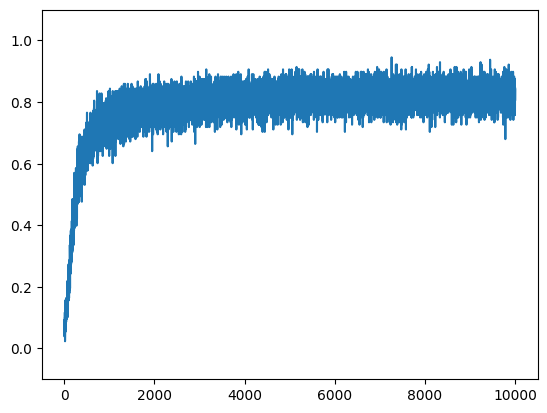

In [19]:
plt.ylim(-0.1, 1.1)
plot(accuracies)


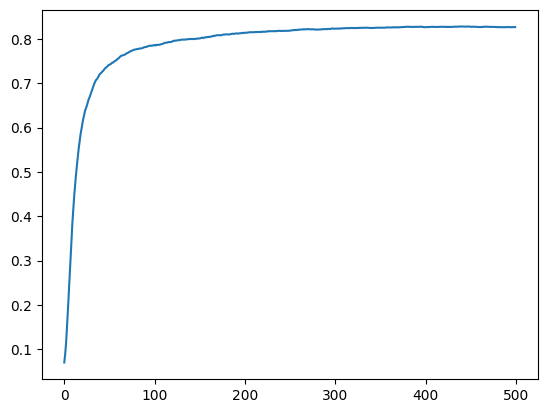

In [20]:
plot(val_accuracies)

In [21]:
test_out=np.argmax(softmax(sigmoid(X_test.dot(l1)).dot(l2)),axis=1)
test_acc=(test_out==Y_test).mean().item()
print(f'Test accuracy = {test_acc*100:.2f}%')


Test accuracy = 83.75%


array([7])

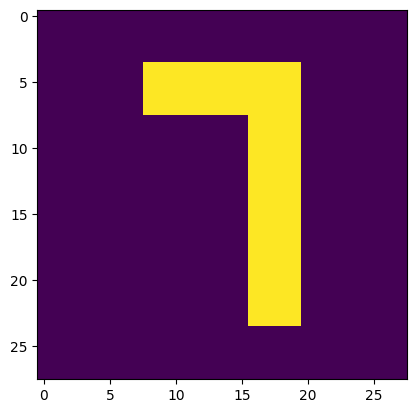

In [22]:
m = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,0,0,0]]

m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
m=m.reshape(1,-1)
imshow(m.reshape(28,28))
x = np.argmax(sigmoid(m.dot(l1)).dot(l2),axis=1)
x

array([1])

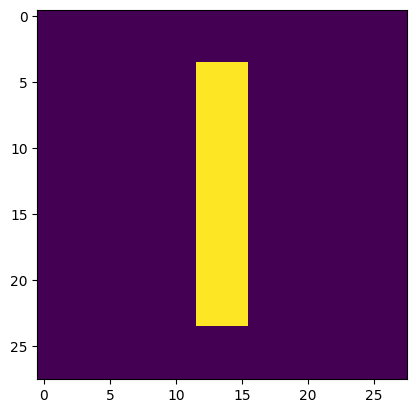

In [23]:
n = [[0,0,0,0,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,0,0,0,0]]

n = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n])
n=n.reshape(1,-1)
imshow(n.reshape(28,28))
x = np.argmax(sigmoid(n.dot(l1)).dot(l2),axis=1)
x